## Revised Data Presentation

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import re
import math
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from ipywidgets import interact
from scipy.signal import savgol_filter


In [4]:
# --- CONFIG ---
folder_path =  r"C:\Users\La Calculadora\Documents\Illimited\VibData"
ext = ".pkl"

# --- Gather all pickle files ---
pickle_files = [f for f in os.listdir(folder_path) if f.endswith(ext)]

# --- Extract Ratio from filenames using regex ---
def get_ratio_and_vib(file_name):
    ratio_match = re.search(r'Ratio_([\d.]+)', file_name)  # Vib power / water Power
    vib_match = re.search(r'Vib_([\d.]+)', file_name) # Vibration Intensity
    
    ratio = float(ratio_match.group(1)) if ratio_match else None
    vib = float(vib_match.group(1)) if vib_match else None
    
    return ratio, vib



# --- Map files to their Ratio group ---
file_params = {file: get_ratio_and_vib(file) for file in pickle_files}
unique_ratios = sorted(set(r for r, vib in file_params.values() if r is not None))
unique_vibs = sorted(set(vib for r, vib in file_params.values() if vib is not None))

# --- Assign one color per Ratio group ---
cmap = cm.get_cmap('tab10', len(unique_ratios))
ratio_colors = {ratio: cmap(i) for i, ratio in enumerate(unique_ratios)}


def trim_motion_start(displacement, threshold=0.15):
    displacement = np.array(displacement)
    abs_disp = np.abs(displacement)
    
    # Find the first index where displacement exceeds the threshold
    start_idx = np.argmax(abs_disp > threshold)
    
    # In case there's never any motion
    if abs_disp[start_idx] <= threshold:
        return displacement  # Or return np.array([]) if you prefer skipping it
    
    return displacement[start_idx:]

vib_power_map = {
    0:	0.0000,
    5:	0.2604,
    10:	0.2940,
    15:	0.2940,
    20:	0.3444,
    25:	0.3612,
    30:	0.3948,
    35:	0.4116,
    40:	0.4536,
    45:	0.4704,
    50:	0.5040,
    55:	0.5208,
    60:	0.5712,
    65:	0.5964,
    70:	0.6300,
    75:	0.6468,
    80:	0.6888,
    85:	0.7224,
    90:	0.7728,
    95:	0.7896,
    100:	0.8148
} # In watts

## Computes longest distance between dots in pixels, hand measured in cm, compared and used to find ppcm
# About 31.5 pixels per cm

point_A = np.array([835,580])
point_B = np.array([799,74])
distane_pxl = np.linalg.norm(point_A-point_B)
distance_cm = 16.1
ppcm = distane_pxl/distance_cm # pixels per cm

print(f"Pixels per centimeter: {ppcm:.2f}")

Pixels per centimeter: 31.51


C:\Users\La Calculadora\AppData\Local\Temp\ipykernel_6252\1763889376.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_ratios))


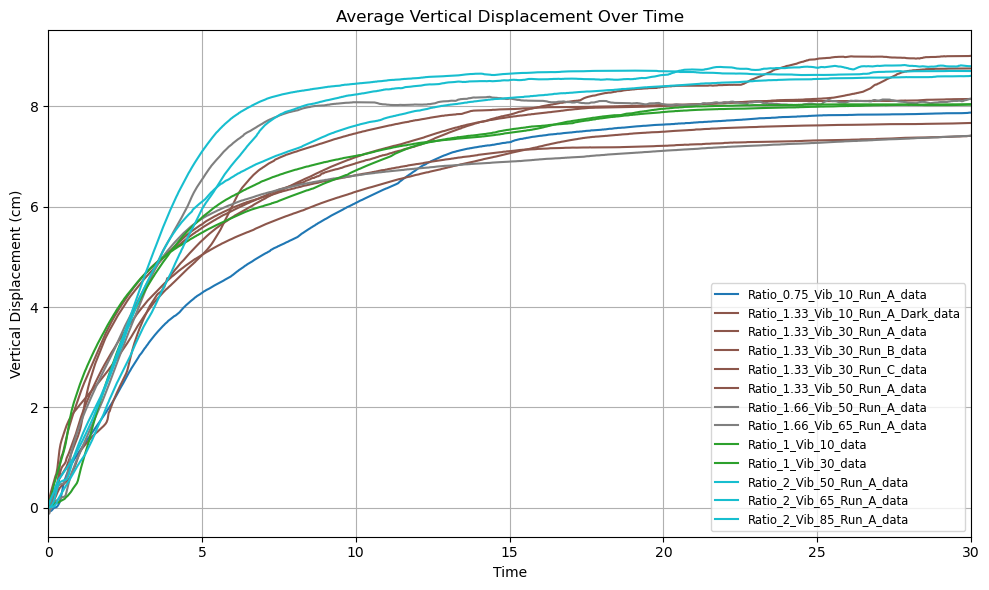

Processed data saved to: C:\Users\La Calculadora\Documents\Illimited\VibData\cum_pp_displacement_data.pkl


In [19]:
# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 6))

# To store the trimmed + averaged displacement data
results = {}

# --- Loop through and plot averaged data per file ---
for file in pickle_files:
    ratio, vib = file_params[file]
    if ratio is None:
        continue  # skip files with no valid ratio
    color = ratio_colors.get(ratio, 'black')  # fallback color
    full_path = os.path.join(folder_path, file)

    with open(full_path, 'rb') as f:
        displacements = pickle.load(f)

    # Trim vertical displacements at start of motion
    trimmed = [trim_motion_start(d[:, 0]) for d in displacements]
    
    # Align lengths by cutting to shortest trimmed signal
    min_len = min(len(d) for d in trimmed)
    trimmed = [d[:min_len] for d in trimmed]

    vertical_mean = np.mean(trimmed, axis=0)


    # Save the trimmed and averaged data
    results[file] = {
        'ratio': ratio,
        'vib': vib,
        'color': color,
        'vertical_mean': vertical_mean,
        'trimmed_raw': trimmed  # Optional: keep the individual trimmed runs too
    }

    label = os.path.splitext(file)[0]
    time = np.linspace(0, len(vertical_mean)/30, len(vertical_mean))  # Assuming 30 FPS
    ax.plot(time, vertical_mean/ppcm, label=label, color=color)

# --- Final formatting ---
ax.set_title("Average Vertical Displacement Over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vertical Displacement (cm)")
ax.grid(True)
ax.legend(fontsize='small', loc='best')
ax.set_xlim(0,30)
plt.tight_layout()
plt.show()


# Define a path to save the processed results
save_path = os.path.join(folder_path, "cum_pp_displacement_data.pkl")

with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Processed data saved to: {save_path}")



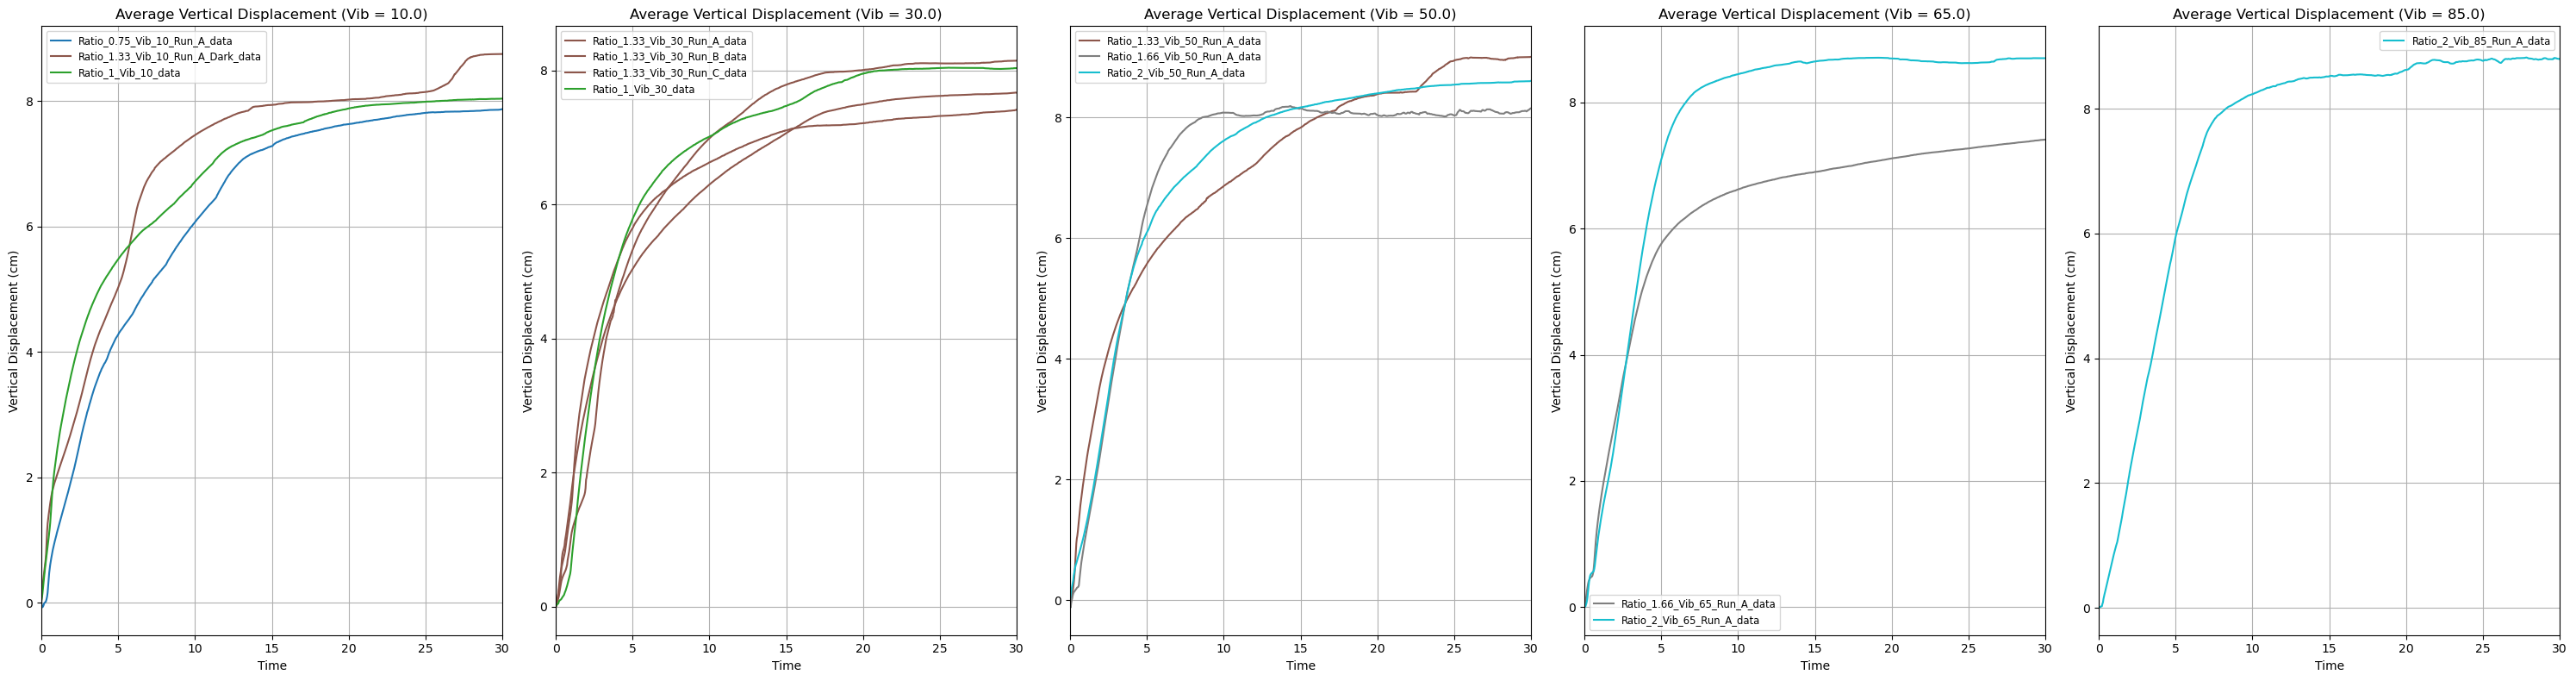

In [21]:
num_vibs = len(unique_vibs)
cols = math.ceil(num_vibs / 2)

# --- Plot setup with subplots per vib value ---

fig, axes = plt.subplots(1, num_vibs, figsize=(30, 8))

# Handle case where there's only one vib value
if num_vibs == 1:
    axes = [axes]

# To store the trimmed + averaged displacement data
results = {}

# --- Loop through and plot averaged data per file ---
for file in pickle_files:
    ratio, vib = file_params[file]
    if ratio is None or vib is None:
        continue  # skip files with no valid ratio or vib
    
    color = ratio_colors.get(ratio, 'black')  # fallback color
    full_path = os.path.join(folder_path, file)

    with open(full_path, 'rb') as f:
        displacements = pickle.load(f)

    # Trim vertical displacements at start of motion
    trimmed = [trim_motion_start(d[:, 0]) for d in displacements]
    
    # Align lengths by cutting to shortest trimmed signal
    min_len = min(len(d) for d in trimmed)
    trimmed = [d[:min_len] for d in trimmed]

    vertical_mean = np.mean(trimmed, axis=0)

    # Save the trimmed and averaged data
    results[file] = {
        'ratio': ratio,
        'vib': vib,
        'color': color,
        'vertical_mean': vertical_mean,
        'trimmed_raw': trimmed
    }

    # Find the subplot index for this vib value
    vib_idx = unique_vibs.index(vib)
    ax = axes[vib_idx]
    
    label = os.path.splitext(file)[0]
    time = np.linspace(0, len(vertical_mean)/30, len(vertical_mean))  # Assuming 30 FPS

    ax.plot(time, vertical_mean/ppcm, label=label, color=color)

# --- Final formatting ---
for vib_idx, vib in enumerate(unique_vibs):
    ax = axes[vib_idx]
    ax.set_title(f"Average Vertical Displacement (Vib = {vib})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Vertical Displacement (cm)")
    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    ax.set_xlim(0, 30)

plt.tight_layout()
plt.show()